# Skew-T's
## Requesting Upper Air Data from Siphon and Plotting a Skew-T with MetPy
### Based on <a href = "http://www.unidata.ucar.edu"> Unidata's </a> <i> MetPy Monday </i> \# 15 -17 YouTube links: <br>https://www.youtube.com/watch?v=OUTBiXEuDIU; <br> https://www.youtube.com/watch?v=oog6_b-844Q; <br> https://www.youtube.com/watch?v=b0RsN9mCY5k

### Import the libraries we need

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import metpy.calc as mpcalc
from metpy.plots import Hodograph, SkewT
from metpy.units import units, pandas_dataframe_to_unit_arrays
from datetime import datetime, timedelta
import pandas as pd
from siphon.simplewebservice.wyoming import WyomingUpperAir

### Next we use methods from the datetime library to determine the latest time, and then use it to select the most recent date and time that we'll use for our selected Skew-T.

In [2]:
now = datetime.utcnow()

curr_year = now.year
curr_month = now.month
curr_day = now.day
curr_hour = now.hour

print("Current time is: ", now)
print("Current year, month, date, hour: " ,curr_year, curr_month,curr_day,curr_hour)

if (curr_hour > 13) :
    raob_hour = 12
    hr_delta = curr_hour - 12
elif (curr_hour > 1):
    raob_hour = 0
    hr_delta = curr_hour - 0
else:
    raob_hour = 12
    hr_delta = curr_hour + 12

raob_time = now - timedelta(hours=hr_delta)

raob_year = raob_time.year
raob_month = raob_time.month
raob_day = raob_time.day
raob_hour = raob_time.hour

print("Time of RAOB is: ", raob_year, raob_month, raob_day, raob_hour)



Current time is:  2023-10-17 17:14:11.106075
Current year, month, date, hour:  2023 10 17 17
Time of RAOB is:  2023 10 17 12


### Construct a datetime object that we will use in our query to the data server. Note what it looks like.

In [3]:
query_date = datetime(raob_year,raob_month,raob_day,raob_hour)
query_date

datetime.datetime(2023, 10, 17, 12, 0)

### If desired, we can choose a past date and time.

In [4]:
#current = True
current = False

In [5]:
if (current == False):
    query_date = datetime(2023, 10, 13, 0)
    
raob_timeStr = query_date.strftime("%Y-%m-%d %H UTC")
raob_timeTitle = query_date.strftime("%H00 UTC %-d %b %Y")
print(raob_timeStr)
print(raob_timeTitle)

2023-10-13 00 UTC
0000 UTC 13 Oct 2023


### Select our station and query the data server.

In [6]:
station = 'LBF'

df = WyomingUpperAir.request_data (query_date,station)

### What does the returned data file look like? Well, it looks like a Pandas Dataframe!

In [7]:
df

,pressure,height,temperature,dewpoint,direction,speed,u_wind,v_wind,station,station_number,time,latitude,longitude,elevation,pw
0,900.0,849.0,9.8,7.4,355.0,11.0,0.958713,-10.958142,LBF,72562,2023-10-13,41.13,-100.68,849.0,21.96
1,895.0,895.0,8.2,5.2,320.0,22.0,14.141327,-16.852978,LBF,72562,2023-10-13,41.13,-100.68,849.0,21.96
2,888.0,960.0,7.6,5.2,326.0,23.0,12.861437,-19.067864,LBF,72562,2023-10-13,41.13,-100.68,849.0,21.96
3,862.0,1202.0,5.8,4.3,350.0,27.0,4.688501,-26.589809,LBF,72562,2023-10-13,41.13,-100.68,849.0,21.96
4,851.0,1307.0,5.0,3.9,355.0,28.0,2.440361,-27.893452,LBF,72562,2023-10-13,41.13,-100.68,849.0,21.96
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,42.0,21792.0,-61.1,-90.5,240.0,4.0,3.464102,2.000000,LBF,72562,2023-10-13,41.13,-100.68,849.0,21.96
101,40.5,22018.0,-59.9,-89.9,247.0,13.0,11.966563,5.079505,LBF,72562,2023-10-13,41.13,-100.68,849.0,21.96
102,40.0,22095.0,-59.7,-83.4,250.0,16.0,15.035082,5.472322,LBF,72562,2023-10-13,41.13,-100.68,849.0,21.96
103,39.4,22190.0,-59.5,-75.5,271.0,15.0,14.997715,-0.261786,LBF,72562,2023-10-13,41.13,-100.68,849.0,21.96


### We need to deal with an issue where two levels may be at the same pressure, but different heights.  While rare, it won't allow a parcel path to be calculated later in this notebook:

We can check to see if this is occurring by looking more closely at the data.  Let's look at the last 30 rows of this dataframe (this issue usually occurs near the very top, or lowest pressures, of our sounding data:

In [8]:
df.tail(30)

,pressure,height,temperature,dewpoint,direction,speed,u_wind,v_wind,station,station_number,time,latitude,longitude,elevation,pw
75,79.0,17885.0,-63.9,-91.9,275.0,13.0,12.950531,-1.133025,LBF,72562,2023-10-13,41.13,-100.68,849.0,21.96
76,74.0,18287.0,-62.0,-91.2,185.0,6.0,0.522934,5.977168,LBF,72562,2023-10-13,41.13,-100.68,849.0,21.96
77,73.0,18371.0,-61.6,-91.0,200.0,8.0,2.736161,7.517541,LBF,72562,2023-10-13,41.13,-100.68,849.0,21.96
78,72.0,18456.0,-61.2,-90.9,170.0,6.0,-1.041889,5.908847,LBF,72562,2023-10-13,41.13,-100.68,849.0,21.96
79,71.0,18542.0,-60.8,-90.8,115.0,9.0,-8.156770,3.803564,LBF,72562,2023-10-13,41.13,-100.68,849.0,21.96
80,70.7,18568.0,-60.7,-90.7,116.0,9.0,-8.089146,3.945340,LBF,72562,2023-10-13,41.13,-100.68,849.0,21.96
81,70.0,18630.0,-60.7,-89.7,120.0,10.0,-8.660254,5.000000,LBF,72562,2023-10-13,41.13,-100.68,849.0,21.96
82,67.0,18901.0,-62.2,-90.8,190.0,4.0,0.694593,3.939231,LBF,72562,2023-10-13,41.13,-100.68,849.0,21.96
83,63.4,19242.0,-64.1,-92.1,239.0,10.0,8.571673,5.150381,LBF,72562,2023-10-13,41.13,-100.68,849.0,21.96
84,63.0,19281.0,-63.8,-92.0,245.0,11.0,9.969386,4.648801,LBF,72562,2023-10-13,41.13,-100.68,849.0,21.96


If any rows have the same pressure, this will cause an error when we call MetPy's `parcel_path` function. Likely this will get resolved in a future release of MetPy, but for now, let's use a Pandas function to eliminate rows whose pressure is the same as a previous row.

In [9]:
df.drop_duplicates(inplace=True,subset='pressure',ignore_index=True)

In [10]:
df['pressure']

0      900.0
1      895.0
2      888.0
3      862.0
4      851.0
       ...  
100     42.0
101     40.5
102     40.0
103     39.4
104     39.0
Name: pressure, Length: 105, dtype: float64

### As with any Pandas Dataframe, we can select columns, so we do so now for all the relevant variables for our Skew-T. Note now that we are using MetPy's <i>units</i> library to attach units to each variable's array of values.

In [11]:
p = df['pressure'].values * units(df.units['pressure'])

In [12]:
#Let's split up the code above, to see more detail:
df['pressure'].values

array([900. , 895. , 888. , 862. , 851. , 850. , 849. , 837. , 836. ,
       831. , 801. , 800. , 772. , 762. , 757. , 752. , 725. , 704. ,
       700. , 692. , 671. , 600. , 594. , 565. , 551. , 531. , 517. ,
       500. , 489. , 465. , 441. , 438. , 414. , 409. , 402. , 400. ,
       397. , 392. , 367. , 365. , 320. , 300. , 298. , 290. , 273. ,
       272. , 269. , 263. , 261. , 250. , 237. , 233. , 227. , 211. ,
       205. , 201. , 200. , 187. , 175. , 174. , 159. , 154. , 150. ,
       143. , 135. , 126. , 117. , 108. , 106. , 100. ,  91. ,  90.5,
        88. ,  85.7,  82. ,  79. ,  74. ,  73. ,  72. ,  71. ,  70.7,
        70. ,  67. ,  63.4,  63. ,  62. ,  60. ,  58.9,  57. ,  56. ,
        54.2,  52. ,  50. ,  49.2,  47.9,  46. ,  45.9,  45. ,  43.3,
        43. ,  42. ,  40.5,  40. ,  39.4,  39. ])

### The University of Wyoming sounding reader includes a <i>units</i> attribute, which produces a Python dictionary of units specific to Wyoming sounding data.  What does it look like? 

In [13]:
df.units

{'pressure': 'hPa',
 'height': 'meter',
 'temperature': 'degC',
 'dewpoint': 'degC',
 'direction': 'degrees',
 'speed': 'knot',
 'u_wind': 'knot',
 'v_wind': 'knot',
 'station': None,
 'station_number': None,
 'time': None,
 'latitude': 'degrees',
 'longitude': 'degrees',
 'elevation': 'meter',
 'pw': 'millimeter'}

In [14]:
#From the dictionary, we can specify pressure units.  In this case, hectopascal (hPa):
units(df.units['pressure'])

1 <Unit('hectopascal')>

In [15]:
#Putting it all together...
p

Magnitude,[900.0 895.0 888.0 862.0 851.0 850.0 849.0 837.0 836.0 831.0 801.0 800.0 772.0 762.0 757.0 752.0 725.0 704.0 700.0 692.0 671.0 600.0 594.0 565.0 551.0 531.0 517.0 500.0 489.0 465.0 441.0 438.0 414.0 409.0 402.0 400.0 397.0 392.0 367.0 365.0 320.0 300.0 298.0 290.0 273.0 272.0 269.0 263.0 261.0 250.0 237.0 233.0 227.0 211.0 205.0 201.0 200.0 187.0 175.0 174.0 159.0 154.0 150.0 143.0 135.0 126.0 117.0 108.0 106.0 100.0 91.0 90.5 88.0 85.7 82.0 79.0 74.0 73.0 72.0 71.0 70.7 70.0 67.0 63.4 63.0 62.0 60.0 58.9 57.0 56.0 54.2 52.0 50.0 49.2 47.9 46.0 45.9 45.0 43.3 43.0 42.0 40.5 40.0 39.4 39.0]
Units,hectopascal


In [16]:
#set this for use later:
p_units=units(df.units['pressure'])

In [17]:
#Set remaining variables and apply units:
Z = df['height'].values * units(df.units['height'])
T = df['temperature'].values * units(df.units['temperature'])
Td = df['dewpoint'].values * units(df.units['dewpoint'])
u = df['u_wind'].values * units(df.units['u_wind'])
v = df['v_wind'].values * units(df.units['v_wind'])

Note: we can also attach units to the various columns using MetPy's `pandas_dataframe_to_unit_arrays` function, as follows:

In [18]:
df = pandas_dataframe_to_unit_arrays(df)

Now that `u` and `v` are *units aware*, we can use one of MetPy's diagnostic routines to calculate the wind speed from the vector's components.

In [19]:
wind_speed = mpcalc.wind_speed(u,v)

Thermodynamic Calculations
--------------------------

Often times we will want to calculate some thermodynamic parameters of a
sounding. The MetPy calc module has many such calculations already implemented!

* **Lifting Condensation Level (LCL)** - The level at which an air parcel's
  relative humidity becomes 100% when lifted along a dry adiabatic path.
* **Parcel Path** - Path followed by a hypothetical parcel of air, beginning
  at the surface temperature/pressure and rising dry adiabatically until
  reaching the LCL, then rising moist adiabatially.

### Calculate the LCL. Note that the units will appear at the end when we print them out!

In [20]:
lclp, lclt = mpcalc.lcl(p[0], T[0], Td[0])
print ('LCL Pressure = ',lclp, 'LCL Temperature = ',lclt)

LCL Pressure =  867.7760249788953 hectopascal LCL Temperature =  6.867679259551153 degree_Celsius


### Calculate the parcel profile. Here, we pass in the array of all pressure values, and specify the first (index 0, remember Python's zero-based indexing) index of the temperature and dewpoint arrays as the starting point of the parcel path.

In [21]:
parcel_prof = mpcalc.parcel_profile(p, T[0], Td[0])

### What does the parcel profile look like? Well, it's just an array of all the temperatures of the parcel at each of the pressure levels as it ascends.

In [22]:
parcel_prof

Magnitude,[282.95 282.4999790512274 281.866922893248 279.72501087202625 279.1596863255055 279.10776600602907 279.05575646069315 278.4245653227347 278.3713673719179 278.10396923223635 276.4482215932588 276.39145038828735 274.75755364172994 274.1523047159502 273.84516963170523 273.5349539730989 271.80407372354165 270.38838290933455 270.1113750019366 269.54999804335796 268.0276498137061 262.28327667980466 261.74977421881886 259.0499036241034 257.66980286786537 255.60424837520637 254.08846137732087 252.1654766812815 250.87057629739087 247.89885172942056 244.7130264207315 244.2989459951843 240.85319435704636 240.10467447442414 239.03842487779434 238.72980960182701 238.26354317712642 237.47744179694794 233.37377042594207 233.0326842071216 224.82644154719978 220.83183486240472 220.41980192645292 218.74800221375767 215.06520106853807 214.84284981271963 214.1718666028243 212.81193975769122 212.35321492517662 209.78025508145373 206.62520273560935 205.6281432985081 204.1082565967049 199.90420198731098 198.26720788347924 197.1563395852805 196.8761094541359 193.137032088076 189.51487912205997 189.20504330381863 184.39610447948436 182.7208957846418 181.35244312561304 178.8934205873357 175.97527877902573 172.54059755370636 168.92580244322642 165.10648500594928 164.22707558254794 161.51563215238818 157.221575224679 156.97427420720973 155.7229114330624 154.5490263389229 152.6124623003609 150.99591882143858 148.20137979998412 147.62639056431325 147.04574741033628 146.45931488818414 146.28223531646165 145.86695237214514 144.05279669806978 141.79753381218092 141.5413492670782 140.89576532005222 139.58194406918057 138.84596255961313 137.5512554384663 136.85741148120044 135.58585757703162 133.99009372976752 132.4969932268103 131.88779954682465 130.88259046008702 129.37777656711043 129.29735516667992 128.56786987383379 127.16101442594749 126.9086679221664 126.05832191634157 124.75526236962781 124.31325455529677 123.77760470839453 123.41725949027001]
Units,kelvin


### Set the limits for the x- and y-axes so they can be changed and easily re-used when desired.

In [23]:
pTop = 100
pBot = 1050
tMin = -60
tMax = 40

### Since we are plotting a skew-T, define the log-p axis.

In [24]:
logTop = np.log10(pTop)
logBot = np.log10(pBot)
interval = np.logspace(logTop,logBot) * p_units

### This interval will tend to oversample points near the top of the atmosphere relative to the bottom. One effect of this will be that wind barbs will be hard to read, especially at higher levels. Use a resampling method from NumPy to deal with this.

In [25]:
idx = mpcalc.resample_nn_1d(p, interval)

### Now we are ready to create our skew-T. Plot it and save it as a PNG file.

<div class="admonition alert alert-warning">
    <p class="admonition-title" style="font-weight:bold">Note:</p>
    Annoyingly, when specifying the color of the dry/moist adiabats, and mixing ratio lines, the parameter must be <b>color<i>s</i></b>, not <b>color</b>. In other Matplotlib-related code lines in the cell below where we set the color, such as <code>skew.ax.axvline</code> ,<b> color</b> must be singular.
</div>

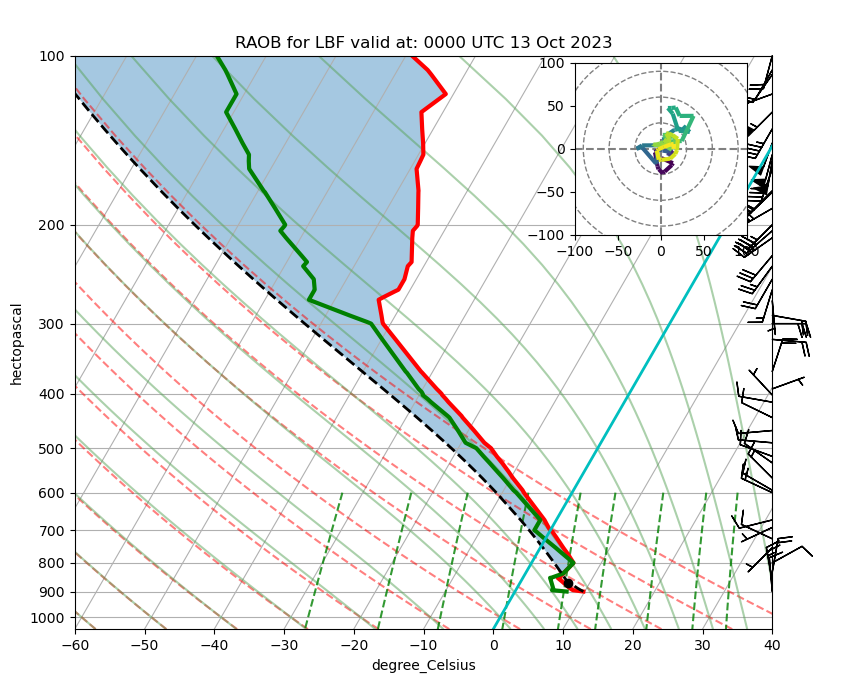

In [26]:
# Create a new figure. The dimensions here give a good aspect ratio
fig = plt.figure(figsize=(9, 9))
skew = SkewT(fig, rotation=30)

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(p, T, 'r', linewidth=3)
skew.plot(p, Td, 'g', linewidth=3)
skew.plot_barbs(p[idx], u[idx], v[idx])
skew.ax.set_ylim(pBot, pTop)
skew.ax.set_xlim(tMin, tMax)

# Plot LCL as black dot
skew.plot(lclp, lclt, 'ko', markerfacecolor='black')

# Plot the parcel profile as a black line
skew.plot(p, parcel_prof, 'k', linestyle='--', linewidth=2)

# Shade areas of CAPE and CIN
skew.shade_cin(p, T, parcel_prof)
skew.shade_cape(p, T, parcel_prof)

# Plot a zero degree isotherm
skew.ax.axvline(0, color='c', linestyle='-', linewidth=2)

# Add the relevant special lines
skew.plot_dry_adiabats()
skew.plot_moist_adiabats(colors='#58a358', linestyle='-')
skew.plot_mixing_lines()

plt.title("RAOB for " + station + ' valid at: '+ raob_timeTitle)

# Create a hodograph
# Create an inset axes object that is 30% width and height of the
# figure and put it in the upper right hand corner.
ax_hod = inset_axes(skew.ax, '30%', '30%', loc=1)
h = Hodograph(ax_hod, component_range=100.)
h.add_grid(increment=30)
#h.plot_colormapped(u, v, df['height'].values)  # Plot a line colored by a parameter
h.plot_colormapped(u, v, df['height'])
plt.savefig (station + raob_timeStr + '_skewt.png')

Here's how the plot would appear if we hadn't done the resampling. Note that the wind barbs are plotted at every level, and are harder to read:

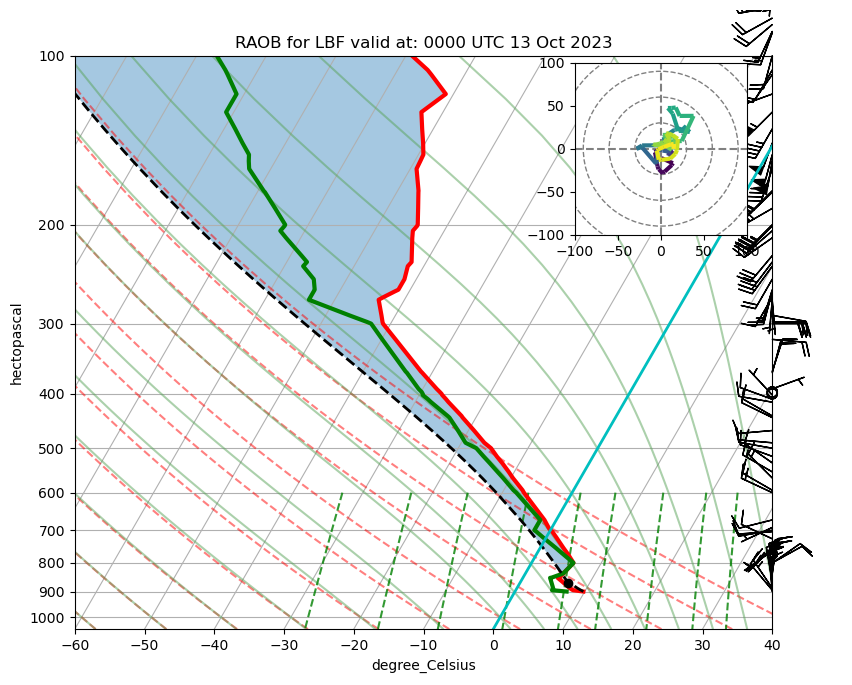

In [27]:
# Create a new figure. The dimensions here give a good aspect ratio
fig = plt.figure(figsize=(9, 9))
skew = SkewT(fig, rotation=30)

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(p, T, 'r', linewidth=3)
skew.plot(p, Td, 'g', linewidth=3)
skew.plot_barbs(p, u, v)
skew.ax.set_ylim(pBot, pTop)
skew.ax.set_xlim(tMin, tMax)

# Plot LCL as black dot
skew.plot(lclp, lclt, 'ko', markerfacecolor='black')

# Plot the parcel profile as a black line
skew.plot(p, parcel_prof, 'k', linestyle='--', linewidth=2)

# Shade areas of CAPE and CIN
skew.shade_cin(p, T, parcel_prof)
skew.shade_cape(p, T, parcel_prof)

# Plot a zero degree isotherm
skew.ax.axvline(0, color='c', linestyle='-', linewidth=2)

# Add the relevant special lines
skew.plot_dry_adiabats()
skew.plot_moist_adiabats(colors='#58a358', linestyle='-')
skew.plot_mixing_lines()

plt.title("RAOB for " + station + ' valid at: '+ raob_timeTitle)

# Create a hodograph
# Create an inset axes object that is 30% width and height of the
# figure and put it in the upper right hand corner.
ax_hod = inset_axes(skew.ax, '30%', '30%', loc=1)
h = Hodograph(ax_hod, component_range=100.)
h.add_grid(increment=30)
h.plot_colormapped(u, v, df['height'])  # Plot a line colored by a parameter